<a href="https://colab.research.google.com/github/jx1e/drqn_pomdp/blob/main/DRQN_Tiger_POMDP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DRQN for the Tiger POMDP

In reinforcement learning, an agent acting in an environment may be modelled by Markov Decision Processes (MDPs). Formally, an MDP is described by a tuple $(S, A, P, R)$, where at each timestep $t$ an
agent interacting with the MDP observes a state $s_t \in S$,
and chooses an action $a_t \in A$ which determines the reward
$r_t \sim R(s_t, a_t)$ and next state $s_{t+1} \sim P(s_t, a_t)$. In environments where the agent cannot observe the fully underlying state, but only observations that may be arbitarily different from states, the MDP may be extended to a POMDP, described by a tuple $(S, A, P, R, Ω, O)$. The difference is that the agent receives observations $o ∈ Ω$ after each reward, and the underlying states $S$ are unknown to the agent.

The Tiger problem is simple POMDP environment with the following dynamics.

A tiger is put with equal probability behind one of two doors, while treasure is put behind the other one. You are standing in front of the two closed doors and need to decide which one to open. If you open the door with the tiger, you will get hurt (negative reward). But if you open the door with treasure, you receive a positive reward. Instead of opening a door right away, you also have the option to wait and listen for tiger noises. But listening is neither free nor entirely accurate. You might hear the tiger behind the left door while it is actually behind the right door and vice versa. (Kamalzadeh and Hahsler, 2021)

The environment was such that opening the door resets the tiger to a random state, so the problem is continuing.

Q-learning is a reinforcement learning algorithm for MDPs that learns the value of an action in a particular state, and finds an optimal policy in the sense of maximizing the expected value of the total reward over any and all successive steps. To deal with MDPs with large state spaces, Deep Q-learning (DQN) (Mnih et al., 2015) uses deep neural networks and Q-learning  to approximate and learn the action-state values $Q(s, a|θ)$. In POMDPs, however, the observation and the underlying states will be different, and estimating a Q-value from an observation can be arbitrarily bad. DRQN (Hausknecht and Stone, 2015) augments the DQN with a recurrent neural network to better estimate the correct action-states values $Q(o, a|θ) ∼ Q(s, a|θ)$. The performance of DRQN has not been studied extensively on benchmark POMDP problems.

The following code implements DRQN, with replay memory, on the Tiger problem (from the library `pomdp_py`). The original DRQN model was simplified, and the model used consists only of a recurrent LSTM layer with 32 hidden units, connected to a fully connected output layer to the Q-values. The idea is that the LSTM learns a mapping from observation-action histories $(o,a)_{0:t}$ to the desired Q-values that give us the optimal policy.


In [ ]:
%%capture
%%bash
apt-get install -y graphviz-dev
pip install pomdp-py

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from collections import deque, namedtuple
import pickle
import random

import torch.nn as nn
import torch

from pomdp_problems.tiger.tiger_problem import *

In [ ]:
init_true_state = random.choice([TigerState("tiger-left"),
                                 TigerState("tiger-right")])
tiger_problem = TigerProblem(0.15, init_true_state, None)

In [ ]:
state2vect = {'tiger-right': np.array([0, 1, 0]), 'tiger-left': np.array([1, 0, 0]), 'tiger-init': np.array([0, 0, 1])}

actions = tiger_problem.agent.policy_model.get_all_actions()
if TigerAction('stay') in actions:
  actions.remove(TigerAction('stay'))

int2action = {0: TigerAction('listen'), 1: TigerAction('open-left'), 2: TigerAction('open-right')}
action2int = {v: k for k, v in int2action.items()}
action2int

{TigerAction(listen): 0, TigerAction(open-left): 1, TigerAction(open-right): 2}

Replay memory

In [ ]:
class ReplayMemory(object):

  def __init__(self, capacity):
    self.memory = deque([],maxlen=capacity)
    self.capacity = capacity

  def push(self, episode):
    self.memory.append(episode)

  def sample(self, batch_size, time_step):
    "Bootstrapped Random Updates."
    sampled_epsiodes = random.sample(self.memory,batch_size)
    batch = []
    for episode in sampled_epsiodes:
        point = np.random.randint(0,len(episode)+1-time_step)
        batch.append(episode[point:point+time_step])
    return batch

  def __len__(self):
   return len(self.memory)

DRQN Model

In [ ]:
class DRQN(nn.Module):
    
    def __init__(self,input_size,out_size):
        super(DRQN,self).__init__()
        self.input_size = input_size
        self.out_size = out_size
        self.lstm_layer = nn.LSTM(input_size=3,hidden_size=32,num_layers=1,batch_first=True)
        self.fc_out = nn.Linear(in_features=32,out_features=self.out_size)
        self.relu = nn.ReLU()
        
    def forward(self,x,bsize,time_step,hidden_state,cell_state):
        x = x.view(bsize, time_step, -1)
        lstm_out = self.lstm_layer(x,(hidden_state,cell_state))
        out = lstm_out[0]
        h_n, c_n = lstm_out[1]
        qout = self.fc_out(out)
        return qout, (h_n,c_n)
    
    def init_hidden_states(self,bsize):
        h = torch.zeros(1,bsize,32).float().to(device)
        c = torch.zeros(1,bsize,32).float().to(device)
        return h,c
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
main_model = DRQN(input_size=3,out_size=3).to(device)
print(main_model)

cpu
DRQN(
  (lstm_layer): LSTM(3, 32, batch_first=True)
  (fc_out): Linear(in_features=32, out_features=3, bias=True)
  (relu): ReLU()
)


Hyper-parameters

In [ ]:
BATCH_SIZE = 32
TIME_STEP = 10
GAMMA = 0.99
INITIAL_EPSILON = 1.0
FINAL_EPSILON = 0.1
TOTAL_EPSIODES = 10000
MAX_STEPS = 30
MEMORY_SIZE = 3000
UPDATE_FREQ = 5
TARGET_UPDATE_FREQ = 500 

In [ ]:
def validate(MAX_STEPS_valid=6):
  hidden_state, cell_state = main_model.init_hidden_states(bsize=1)
  reward_stat_valid = []
  total_reward_valid = 0
  MAX_STEPS_valid = MAX_STEPS_valid
  true_state = random.choice([TigerState("tiger-left"),TigerState("tiger-right")])
  step_count_valid = 0
  print("Valid Episode", episode+1, "Step", step_count_valid)
  print("True state", true_state)
  processed_prev_state = state2vect['tiger-init'].astype(np.float64)
  with torch.no_grad():
    while step_count_valid < MAX_STEPS_valid:
      step_count_valid +=1
      with torch.no_grad():
        torch_x = torch.from_numpy(processed_prev_state).float().to(device)
        model_out = main_model.forward(torch_x,bsize=1,time_step=1,hidden_state=hidden_state,cell_state=cell_state)
        out = model_out[0]
        action = int(torch.argmax(out[0]))
        action = int2action[action]
      print(action.name)
      hidden_state = model_out[1][0]
      cell_state = model_out[1][1]
      next_state = ObservationModel().sample(true_state, action)
      next_state = TigerState(next_state.name)
      if action.name != "listen":
          processed_next_state = state2vect['tiger-init']
      else:
          processed_next_state = state2vect[next_state.name]       
      print(next_state)
      reward = RewardModel().sample(true_state, action, None)
      total_reward_valid += reward
      print(reward)
      if action.name != "listen":
          true_state = next_state
          print("true state", true_state)

      processed_prev_state = processed_next_state
          
  reward_stat_valid.append(total_reward_valid)
  print("\n")

In [ ]:
def optimize_model():
  if len(mem) < BATCH_SIZE:
    return

  hidden_batch, cell_batch = main_model.init_hidden_states(bsize=BATCH_SIZE)
  
  batch = mem.sample(BATCH_SIZE,TIME_STEP)
  
  current_states = []
  acts = []
  rewards = []
  next_states = []
  
  for b in batch:
      cs,ac,rw,ns = [],[],[],[]
      for element in b:
          cs.append(element[0])
          ac.append(element[1])
          rw.append(element[2])
          ns.append(element[3])
      current_states.append(cs)
      acts.append(ac)
      rewards.append(rw)
      next_states.append(ns)
  
  current_states = np.array(current_states).astype(np.float64)
  acts = np.array(acts).astype(np.float64)
  rewards = np.array(rewards).astype(np.float64)
  next_states = np.array(next_states).astype(np.float64)
  
  torch_current_states = torch.from_numpy(current_states).float().to(device)
  torch_acts = torch.from_numpy(acts).long().to(device)
  torch_rewards = torch.from_numpy(rewards).float().to(device)
  torch_next_states = torch.from_numpy(next_states).float().to(device)
  
  Q_next,_ = target_model.forward(torch_next_states,bsize=BATCH_SIZE,time_step=TIME_STEP,hidden_state=hidden_batch,cell_state=cell_batch)
  Q_next_max,__ = Q_next.detach().max(dim=2)
  target_values = torch_rewards + (GAMMA * Q_next_max)
    
  Q_s, _ = main_model.forward(torch_current_states,bsize=BATCH_SIZE,time_step=TIME_STEP,hidden_state=hidden_batch,cell_state=cell_batch)
  Q_s_a = Q_s.gather(dim=2,index=torch_acts.unsqueeze(dim=2)).squeeze()
  
  loss = criterion(Q_s_a,target_values)
  loss_stat.append(loss.item())
  optimizer.zero_grad()
  loss.backward()
  nn.utils.clip_grad_value_(main_model.lstm_layer._parameters.values(), 10)   
  optimizer.step()


In [ ]:
main_model = DRQN(input_size=3,out_size=3).float().to(device)
target_model = DRQN(input_size=3,out_size=3).float().to(device)
target_model.load_state_dict(main_model.state_dict())
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(main_model.parameters(),lr=0.00025)

mem = ReplayMemory(MEMORY_SIZE)

# Training the model

In [ ]:
epsilon = INITIAL_EPSILON
loss_stat = []
reward_stat = []
total_steps = 0

for episode in range(0,TOTAL_EPSIODES):
    
    true_state = random.choice([TigerState("tiger-left"),TigerState("tiger-right")])
    processed_prev_state = state2vect['tiger-init'].astype(np.float64)
    total_reward = 0
    step_count = 0
    local_memory = []

    hidden_state, cell_state = main_model.init_hidden_states(bsize=1)
    
    while step_count < MAX_STEPS:
        
        step_count +=1
        total_steps +=1
        
        if np.random.rand(1) < epsilon:
            torch_x = torch.from_numpy(processed_prev_state).float().to(device)
            model_out = main_model.forward(torch_x,bsize=1,time_step=1,hidden_state=hidden_state,cell_state=cell_state)
            action = random.sample(actions,1)[0]
            hidden_state = model_out[1][0]
            cell_state = model_out[1][1]
            
        else:
            torch_x = torch.from_numpy(processed_prev_state).float().to(device)
            model_out = main_model.forward(torch_x,bsize=1,time_step=1,hidden_state=hidden_state,cell_state=cell_state)
            out = model_out[0]
            action = int(torch.argmax(out[0]))
            action = int2action[action]
            hidden_state = model_out[1][0]
            cell_state = model_out[1][1]
        
        next_state = ObservationModel().sample(true_state, action)
        next_state = TigerState(next_state.name)
        reward = RewardModel().sample(true_state, action, None)/100

        if action.name != "listen":
          processed_next_state = state2vect['tiger-init']
        else:
          processed_next_state = state2vect[next_state.name]
        
        local_memory.append((processed_prev_state,action2int[action],reward,processed_next_state))

        if action.name != "listen":
          true_state = next_state
        processed_prev_state = processed_next_state
        action = action2int[action]
        
        if (total_steps % TARGET_UPDATE_FREQ) == 0:
            target_model.load_state_dict(main_model.state_dict())
       
        if (total_steps % UPDATE_FREQ) == 0: # Update every 5 steps
            optimize_model()  

    reward_stat.append(total_reward)
    
    mem.push(local_memory)

    if epsilon > FINAL_EPSILON:
        epsilon -= (INITIAL_EPSILON - FINAL_EPSILON)/TOTAL_EPSIODES

    if (episode+1) % (TOTAL_EPSIODES/10) == 0:
        validate()
        diff_network_optimal()

Valid Episode 1000 Step 0
True state tiger-right
listen
tiger-right
-1
listen
tiger-right
-1
open-left
tiger-right
10
true state tiger-right
listen
tiger-right
-1
listen
tiger-right
-1
listen
tiger-left
-1


2.222
Valid Episode 2000 Step 0
True state tiger-left
listen
tiger-left
-1
listen
tiger-right
-1
listen
tiger-left
-1
listen
tiger-left
-1
listen
tiger-left
-1
listen
tiger-left
-1


1.237
Valid Episode 3000 Step 0
True state tiger-right
listen
tiger-right
-1
listen
tiger-right
-1
open-left
tiger-right
10
true state tiger-right
listen
tiger-right
-1
listen
tiger-right
-1
open-left
tiger-right
10
true state tiger-right


0.827
Valid Episode 4000 Step 0
True state tiger-right
listen
tiger-right
-1
listen
tiger-right
-1
open-left
tiger-right
10
true state tiger-right
listen
tiger-right
-1
listen
tiger-right
-1
open-left
tiger-left
10
true state tiger-left


1.974
Valid Episode 5000 Step 0
True state tiger-left
listen
tiger-left
-1
listen
tiger-left
-1
open-right
tiger-left
10
true sta

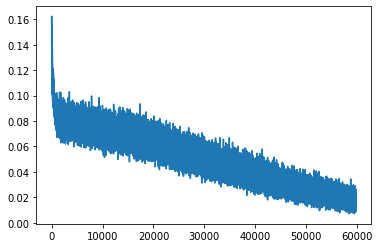

In [ ]:
plt.plot(loss_stat)

# Testing the model

In [ ]:
def test_network(MAX_STEPS=6):
  TOTAL_EPSIODES = 1000
  loss_stat = []
  reward_stat = []
  total_steps = 0
  MAX_STEPS = MAX_STEPS

  for episode in range(0,TOTAL_EPSIODES):
      
      true_state = random.choice([TigerState("tiger-left"),TigerState("tiger-right")])
      processed_prev_state = state2vect['tiger-init'].astype(np.float64)
      total_reward = 0
      step_count = 0

      hidden_state, cell_state = main_model.init_hidden_states(bsize=1)

      while step_count < MAX_STEPS:
          
          step_count +=1
          total_steps +=1

          with torch.no_grad():
            torch_x = torch.from_numpy(processed_prev_state).float().to(device)
            model_out = main_model.forward(torch_x,bsize=1,time_step=1,hidden_state=hidden_state,cell_state=cell_state)
            out = model_out[0]
            action = int(torch.argmax(out[0]))
            action = int2action[action]

          hidden_state = model_out[1][0]
          cell_state = model_out[1][1]

          next_state = ObservationModel().sample(true_state, action)
          next_state = TigerState(next_state.name)
          reward = RewardModel().sample(true_state, action, None)
          total_reward += reward

          if action.name != "listen":
            processed_next_state = state2vect['tiger-init']
            true_state = next_state
          else:
            processed_next_state = state2vect[next_state.name]       

          processed_prev_state = processed_next_state
              
      reward_stat.append(total_reward)
  return np.mean(reward_stat)


Test the network for 10 timesteps, and plot the mean reward.

8.04396 0.9177013557797546


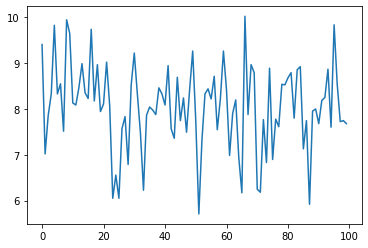

In [ ]:
avg = [test_network(10) for i in range(100)]
plt.plot(avg)
print(np.mean(avg), np.std(avg))

The optimal policy for the Tiger problem with observation noise $p=0.15$ is to listen until the tiger is observed twice more on one side 
than the other, at which point you choose to open (Cassandra et al., 1994).

In [ ]:
def test_optimal(MAX_STEPS=6):
  TOTAL_EPSIODES = 1000
  loss_stat = []
  reward_stat = []
  total_steps = 0
  MAX_STEPS = MAX_STEPS

  for episode in range(0,TOTAL_EPSIODES):
      
      true_state = random.choice([TigerState("tiger-left"),TigerState("tiger-right")])
      processed_prev_state = state2vect['tiger-init'].astype(np.float64)
      total_reward = 0
      step_count = 0
      
      hidden_state, cell_state = main_model.init_hidden_states(bsize=1)
      left_count = 0
      right_count = 0
      while step_count < MAX_STEPS:
          
          step_count +=1
          total_steps +=1
          hidden_state = model_out[1][0]
          cell_state = model_out[1][1]
          
          if left_count - right_count == 2:
            action = TigerAction("open-right")
          elif right_count - left_count ==2:
            action = TigerAction("open-left")
          else:
            action = TigerAction("listen")

          next_state = ObservationModel().sample(true_state, action)
          next_state = TigerState(next_state.name)
          reward = RewardModel().sample(true_state, action, None)
          total_reward += reward

          if next_state.name == "tiger-left":
            left_count +=1
          else:
            right_count += 1


          if action.name != "listen":
            left_count = 0
            right_count = 0
            true_state = next_state

          if action.name != "listen":
            processed_next_state = state2vect['tiger-init']
            true_state = next_state
          else:
            processed_next_state = state2vect[next_state.name]       
          
          processed_prev_state = processed_next_state
              
      reward_stat.append(total_reward)
  return np.mean(reward_stat)


Here, we observe that the average reward for the optimal policy is similar to the learnt policy.

8.10237 0.9981008130945491


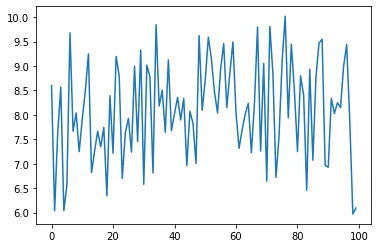

In [ ]:
avg = [test_optimal(10) for i in range(100)]
plt.plot(avg)
print(np.mean(avg), np.std(avg))

Inspectig the learnt policy gives us confidence that it is the optimal policy.

In [ ]:
for i in range(10):
  episode = i
  validate()

Valid Episode 1 Step 0
True state tiger-left
listen
tiger-right
-1
listen
tiger-left
-1
listen
tiger-left
-1
listen
tiger-left
-1
open-right
tiger-left
10
true state tiger-left
listen
tiger-left
-1


Valid Episode 2 Step 0
True state tiger-left
listen
tiger-left
-1
listen
tiger-left
-1
open-right
tiger-right
10
true state tiger-right
listen
tiger-right
-1
listen
tiger-left
-1
listen
tiger-right
-1


Valid Episode 3 Step 0
True state tiger-left
listen
tiger-left
-1
listen
tiger-left
-1
open-right
tiger-right
10
true state tiger-right
listen
tiger-right
-1
listen
tiger-right
-1
open-left
tiger-left
10
true state tiger-left


Valid Episode 4 Step 0
True state tiger-right
listen
tiger-right
-1
listen
tiger-right
-1
open-left
tiger-right
10
true state tiger-right
listen
tiger-right
-1
listen
tiger-right
-1
open-left
tiger-right
10
true state tiger-right


Valid Episode 5 Step 0
True state tiger-left
listen
tiger-right
-1
listen
tiger-left
-1
listen
tiger-right
-1
listen
tiger-left
-1
listen

In fact, we can show that the learnt policy is optimal up to 10 time steps.

In [ ]:
def diff_network_optimal(MAX_STEPS=10):
  TOTAL_EPSIODES = 1000
  loss_stat = []
  reward_stat = []
  total_steps = 0
  diff = 0
  MAX_STEPS = MAX_STEPS

  for episode in range(0,TOTAL_EPSIODES):
      
      true_state = random.choice([TigerState("tiger-left"),TigerState("tiger-right")])
      processed_prev_state = state2vect['tiger-init'].astype(np.float64)
      total_reward = 0
      step_count = 0
      
      hidden_state, cell_state = main_model.init_hidden_states(bsize=1)
      left_count = 0
      right_count = 0
      while step_count < MAX_STEPS:
          
          step_count +=1
          total_steps +=1
          
          if left_count - right_count == 2:
            action_op = TigerAction("open-right")
          elif right_count - left_count ==2:
            action_op = TigerAction("open-left")
          else:
            action_op = TigerAction("listen")

          with torch.no_grad():
            torch_x = torch.from_numpy(processed_prev_state).float().to(device)
            model_out = main_model.forward(torch_x,bsize=1,time_step=1,hidden_state=hidden_state,cell_state=cell_state)
            out = model_out[0]
            action = int(torch.argmax(out[0]))
            action = int2action[action]

          if action_op.name != action.name:
            diff += 1

          hidden_state = model_out[1][0]
          cell_state = model_out[1][1]

          next_state = ObservationModel().sample(true_state, action)
          next_state = TigerState(next_state.name)
          reward = RewardModel().sample(true_state, action, None)
          total_reward += reward

          if next_state.name == "tiger-left":
            left_count +=1
          else:
            right_count += 1

          if action.name != "listen":
            left_count = 0
            right_count = 0
            true_state = next_state

          if action.name != "listen":
            processed_next_state = state2vect['tiger-init']
            true_state = next_state
          else:
            processed_next_state = state2vect[next_state.name]       
          
          processed_prev_state = processed_next_state
              
      reward_stat.append(total_reward)
  print(diff)
  return diff


In [ ]:
np.sum(np.array([diff_network_optimal() for i in range(100)]))/100

It was verified that the learnt policy is the optimal policy, up to 20 timesteps.

In [ ]:
diff_network_optimal(20)

0


0

19.15032 1.3645962471002182


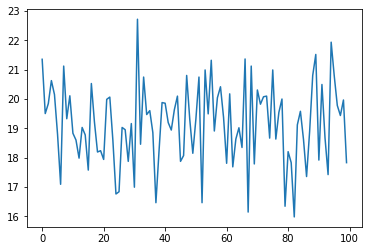

In [ ]:
avg = [test_network(20) for i in range(100)]
plt.plot(avg)
print(np.mean(avg), np.std(avg))

19.428729999999998 1.483443911005738


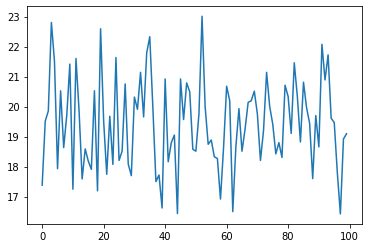

In [ ]:
avg = [test_optimal(20) for i in range(100)]
plt.plot(avg)
print(np.mean(avg), np.std(avg))

**References**


*    Hahsler, Michael., Kamalzadeh, Hossein. 2021. "POMDP: Introduction to Partially Observable Markov Decision Processes".
*   Cassandra, Anthony R., Leslie Pack Kaelbling, and Michael L. Littman. 1994. “Acting Optimally in Partially Observable Stochastic Domains.” In Proceedings of the Twelfth National Conference on Artificial Intelligence. Seattle, WA.
*    Mnih, V., Kavukcuoglu, K., Silver, D. et al. Human-level control through deep reinforcement learning. Nature 518, 529–533 (2015). 
*    Hausknecht, M., & Stone, P. (2015, September). Deep recurrent q-learning for partially observable mdps. In 2015 aaai fall symposium series.


